In [1]:
try:
# %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random

In [2]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)

def create_pairs_on_set(images, labels):
    
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    
    return pairs, y


def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [3]:
# load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# prepare train and test sets
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# normalize values
train_images = train_images / 255.0
test_images = test_images / 255.0

# create pairs on train and test sets
tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

4431872/4422102 [==============================] - 1s 0us/step


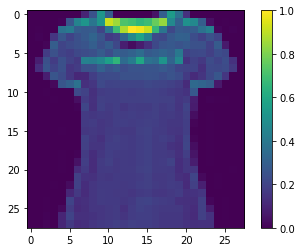

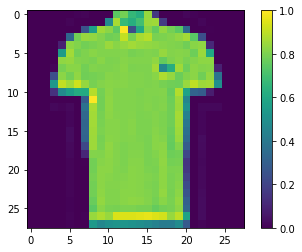

1.0


In [5]:
# array index
this_pair = 8

# show images at this index
show_image(ts_pairs[this_pair][0])
show_image(ts_pairs[this_pair][1])

# print the label for this pair
print(ts_y[this_pair])

In [7]:
def initialize_base_network():
    input = Input(shape=(28,28,), name="base_input")
    x = Flatten(name="flatten_input")(input)
    x = Dense(128, activation='relu', name="first_base_dense")(x)
    x = Dropout(0.1, name="first_dropout")(x)
    x = Dense(128, activation='relu', name="second_base_dense")(x)
    x = Dropout(0.1, name="second_dropout")(x)
    x = Dense(128, activation='relu', name="third_base_dense")(x)

    return Model(inputs=input, outputs=x)


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [10]:
!pip install pydot
!pip install graphviz
base_network = initialize_base_network()
plot_model(base_network, show_shapes=True, show_layer_names=True, to_file='base-model.png')

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7.
DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7.
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [11]:
# create the left input and point to the base network
input_a = Input(shape=(28,28,), name="left_input")
vect_output_a = base_network(input_a)

# create the right input and point to the base network
input_b = Input(shape=(28,28,), name="right_input")
vect_output_b = base_network(input_b)

# measure the similarity of the two vector outputs
output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

# specify the inputs and output of the model
model = Model([input_a, input_b], output)

In [12]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [ ]:
rms = RMSprop()
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)
history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, epochs=20, batch_size=128, validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))

W0124 16:27:21.002542 4459660736 deprecation.py:323] From /anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/math_grad.py:1250: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 119980 samples, validate on 19980 samples
Epoch 1/20


In [ ]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)